---
이 글은 kaggle의 Computer Vision 강의를 번역한 것입니다.

(오역 및 잘못된 부분이 많으니 참고 바랍니다.)

---

<!--TITLE: Convolution and ReLU-->

In [1]:
import numpy as np
from itertools import product

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

# Introduction #

지난 강의에서 합성곱(Convolutional) 분류기는 Convolution **base**와 dense 레이어의 **head** 두 부분으로 구성되어 있음을 확인했습니다. 우리는 base의 역할이 이미지에서 시각적 특징을 추출(Extract visual features)하는 것임을 배웠습니다. 그러면 Head가 이미지를 분류하는 데 사용합니다.

다음 몇 가지 강의를 통해 합성곱(Convolutional) 이미지 분류기 base에서 일반적으로 찾을 수있는 가장 중요한 두 가지 유형의 레이어에 대해 알아볼 것입니다.
1. **ReLU 활성화(Activiation)**가 있는 **Convolutional 레이어**
2. **Maximum pooling 레이어**입니다. 

5강에서는 이러한 레이어를 특성 추출(Feature Extraction)을 수행하는 블록으로 구성하여 자신만의 Convnet을 설계하는 방법을 배웁니다.

이 강의는 ReLU 활성화 기능이 있는 합성곱 레이어(Convolutional layer)에 대한 것입니다.


# Feature Extraction #

합성곱(Convolution)에 대해 자세히 알아보기 전에, 신경망에서 이런 레이어의 *목적*에 대해 토의하겠습니다. 세 가지 operation들을(Convolution, ReLU, 그리고 Maximum pooling) 사용하여 Feature Extraction 과정을 구현하는 방법을 살펴 보겠습니다.

Base가 수행하는 **Feature Extraction**은 세 가지 기본 operation으로 구성됩니다.
1. **Filter** : 하나의 특정 feature에 대한 이미지를 필터링합니다. (Convolution)
2. **Detect** : 필터링된 이미지 내의 Feature를 탐지합니다. (ReLU)
3. **Condense** : Feature 강화를 위해 이미지를 압축합니다. (Maximum pooling)

다음 그림은 이 과정을 시각적으로 보여줍니다. 이 세 가지 작업이 원본 이미지의 특별한 특징(이 경우에는 수평선)을 분리하는 방법을 확인할 수 있습니다.

<figure>
<!-- <img src="./images/2-show-extraction.png" width="1200" alt="An example of the feature extraction process."> -->
<img src="https://i.imgur.com/IYO9lqp.png" width="600" alt="An example of the feature extraction process.">
<figcaption style="textalign: center; font-style: italic"><center>The three steps of feature extraction.</center></figcaption>
</figure>

일반적으로 네트워크는 단일 이미지에서 여러 추출을 병렬로 수행합니다. 현대의 Convnet에서 base의 최종 레이어가 1,000개 이상의 고유한 시각적 Feature들을 생성하는 것은 드문 일이 아닙니다.


# Filter with Convolution #

합성곱 레이어(Convolutional layer)는 필터링 단계를 수행합니다. Keras 모델에서 다음과 같이 합성곱 레이어를 정의할 수 있습니다.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    # More layers follow
])

레이어의 *가중치(Weights)*와 *활성화(Activiations)*의 관계를 살펴보면 이러한 파라미터들을 이해할 수 있습니다. 이제 살펴봅시다.

## Weights ##

Convnet이 학습(Training)하는 동안 사용하는 **가중치**는 주로 합성곱 레이어에 포함됩니다. 이러한 가중치를 우리는 **커널(Kernels)**이라고 부릅니다. 우리는 이것들을 작은 배열(Arrays)로 표현할 수 있습니다.

<figure>
<!-- <img src="./images/3-kernel.png" width="150" alt="A 3x3 kernel."> -->
<img src="https://i.imgur.com/uJfD9r9.png" width="150" alt="A 3x3 kernel.">
</figure>

커널은 이미지를 스캔하고 픽셀(pixel) 값의 *가중 합계(Weighted sum)*를 생성하여 작동합니다. 이런 식으로, 커널은 특정 패턴의 정보를 강조하거나 강조하지 않는 일종의 편광 렌즈처럼 작동합니다.

<figure>
<!-- <img src="./images/3-kernel-lens.png" width="400" alt="A kernel acts as a kind of lens."> -->
<img src="https://i.imgur.com/j3lk26U.png" width="250" alt="A kernel acts as a kind of lens.">
<figcaption style="textalign: center; font-style: italic"><center>A kernel acts as a kind of lens.</center></figcaption>
</figure>

커널은 합성곱 레이어가 다음 레이어에 연결되는 방식을 정의합니다. 위의 커널은 출력단에 있는 각 뉴런(neuron)을 9개의 입력 뉴런에 연결합니다. 커널 크기를 `kernel_size`로 설정하면 Convnet에 이러한 연결을 형성하는 방법을 알려줍니다. 대부분의 경우 커널은 -- `kernel_size = (3, 3)`또는`(5, 5)`와 같은 -- 홀수 차원을 가지므로 단일 픽셀이 중앙에 배치되는데 이는 필수 사항은 아닙니다.

합성곱 레이어의 커널은 생성되는 feature의 종류를 결정합니다. 학습 동안에 Convnet은 분류 문제를 해결하는데 필요한 feature들을 배우려고 시도합니다. 이것은 커널에 가장 적합한 값을 찾는 것을 의미합니다.

<!--TODO: Learning a kernel-->

## Activations ##

신경망의 활성화(Activations)는 **Feature Maps**으로 부릅니다. 이는 이미지에 필터를 적용한 결과입니다. 

여기에는 커널이 추출하는 시각적 Feature들이 포함되어 있습니다. 다음은 그들이 생성 한 Feature Map으로 묘사 된 몇 가지 커널입니다.

<figure>
<img src="https://i.imgur.com/JxBwchH.png" width="800" alt="Three kernels and the feature maps they produce."><figcaption style="textalign: center; font-style: italic"><center>Kernels and features.</center></figcaption>
</figure>

커널의 패턴의 수를 통해, 당신은 커널이 생성하는 Feature maps의 종류를 말할 수 있습니다. 일반적으로 합성곱(Convolution)이 입력에서 강조하는 것은 커널의 *pisitive* 숫자들의 모양과 일치합니다. 위의 왼쪽 및 중간 커널은 모두 수평 모양을 필터링 합니다.

`filters` 파라미터를 사용해서 출력으로 생성할 Feature map이 얼마나 있는지 합성곱 레이어에 알려줄 수 있습니다.


# Detect with ReLU #

필터링 과정 이후 Feature map들은 활성화 함수(Activiation Function)을 통과합니다. **Rectifier Function**은 아래와 같은 그래프입니다:

<figure>
<!-- <img src="./images/relu.png" width="300" alt=""> -->
<img src="https://i.imgur.com/DxGJuTH.png" width="300" alt="Graph of the ReLU activation function.">
<figcaption style="textalign: center; font-style: italic"><center>The graph of the rectifier function looks like a line with the negative part "rectified" to 0.</center></figcaption>
</figure>

Rectifier가 부착된 뉴런을 *Rectified Linear Unit*이라고 부릅니다. 이러한 배경때문에 Rectifier Function을 **ReLU activation** 혹은 아예 ReLU function으로 부르기도 합니다.

ReLU 활성화(Activation)는 자체 `Activation` 레이어로 정의될 수 있지만 대부분의 경우 `Conv2D`의 활성화 기능으로 포함합니다.

In [3]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu')
    # More layers follow
])

활성화 함수(Activation Function)는 중요도에 따라 픽셀 값을 채점하는 것으로 생각할 수 있습니다. ReLU 활성화는 음수 값이 중요하지 않다는 것을 나타내므로 이를 0으로 설정합니다 ( "중요하지 않은 모든 것은 똑같이 중요하지 않습니다.").

위의 Feature map을 적용한 ReLU는 다음과 같습니다. ReLU가 Feature들을 분리하는데 어떻게 성공하는지 확인하십시오.


<figure>
<!-- <img src="./images/3-relu-and-maps.png" width="800" alt="ReLU applied to feature maps."> -->
<img src="https://i.imgur.com/dKtwzPY.png" width="800" alt="ReLU applied to feature maps.">
</figure>

다른 활성화 함수와 마찬가지로 ReLU 함수는 **비선형(Non-linear)**입니다. 본질적으로 이것은 신경망에 모든 레이어의 전체 효과(Total Effect)가 그냥 모든 효과를 더하여 얻을 수 있는 것과 달라진다는 것을 의미합니다. -- 이것은 단일 레이어(single layer)로만 달성 할 수있는 것과 동일합니다. 비선형성은 Feature가 신경망 깊숙이 이동할 때 흥미로운 방식으로 결합되도록 합니다. (5강에서 이 "Feature 합성(Feature Compounding)"에 대해 자세히 살펴 보겠습니다.)


# Example - Apply Convolution and ReLU #

합성곱(Convolutional) 레이어가 "뒤에서" 수행하는 작업을 더 잘 이해하기 위해 아래 예제에서 직접 Extraction을 수행합니다.

이 예제에 사용할 이미지는 다음과 같습니다:

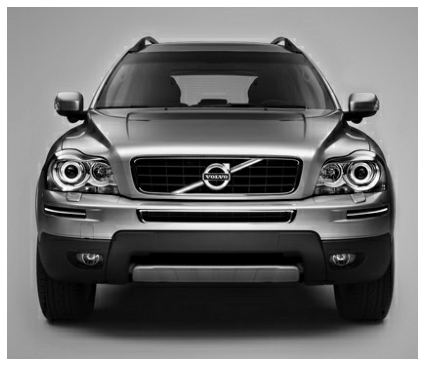

In [4]:

import tensorflow as tf
import matplotlib.pyplot as plt
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image_path = '../input/computer-vision-resources/car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show();

필터링 단계에서는 커널을 정의한 다음 이것을 합성곱(Convolution)과 함께 적용합니다. 이 경우 커널은 "Edge Detection"커널입니다. Numpy에서 `np.array`로 배열을 정의하는 것처럼`tf.constant`로 정의 할 수 있습니다. 이것은 TensorFlow가 사용하는 종류의 *tensor*를 생성합니다.

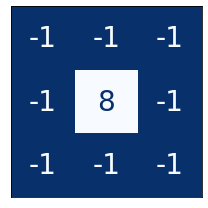

In [5]:
import tensorflow as tf

kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
])

plt.figure(figsize=(3, 3))
show_kernel(kernel)

TensorFlow는 `tf.nn` [module](https://www.tensorflow.org/api_docs/python/tf/nn)에 신경망이 수행하는 많은 기본 operation들을 포함하고 있습니다. 우리가 사용할 두 가지는 `conv2d`와 `relu`입니다. 이들은 단순히 Keras 레이어의 function 버전(역주: 함수로 제공한다는 뜻)입니다.

다음 hidden cell은 TensorFlow와 호환되도록 형식을 다시 지정합니다. 이 예에서는 세부 정보가 중요하지 않습니다.

In [6]:
# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

이제 커널을 적용하고 무슨 일이 일어나는지 봅시다.

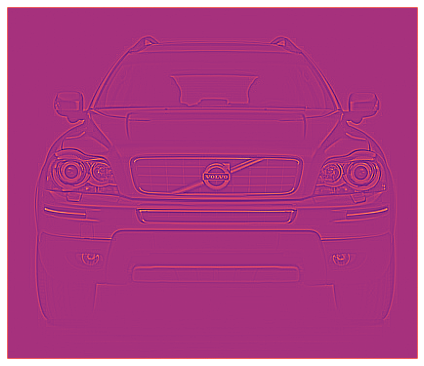

In [7]:
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    # we'll talk about these two in lesson 4!
    strides=1,
    padding='SAME',
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.show();

다음은 ReLU 기능을 사용한 Detection 단계입니다. 이 함수는 설정할 파라미터가 없기 때문에 합성곱(Convolution)보다 훨씬 간단합니다.

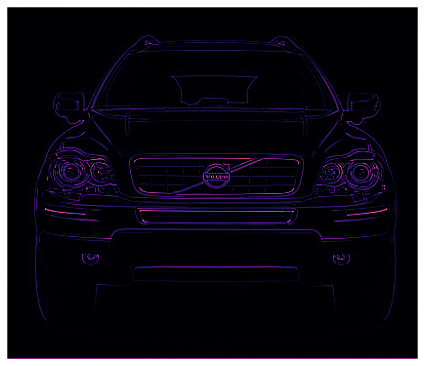

In [8]:
image_detect = tf.nn.relu(image_filter)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.show();

Feature map을 만들었습니다! 이와 같은 이미지는 Head가 분류 문제(Classification problem)를 해결하는 데 사용하는 것입니다. 특정 Feature는 *차(Cars)*의 특징이고 다른 Feature는 *트럭(Trucks)*의 특징 일 수 있습니다. 학습 중 Convnet의 임무는 이러한 기능을 찾을 수있는 커널을 만드는 것입니다.


# Conclusion #

이 강의에서 Convnet이 Feature Extraction을 수행하는 데 사용하는 처음 두 단계를 배웠습니다.
- `Conv2D` 레이어로 **filter**
- `relu` 활성화로 **detect**


# Your Turn #

[**2강 실전 문제**](https://www.kaggle.com/kernels/fork/11989557)에서 1강에서 사용한 사전 훈련된 VGG16 모델의 커널을 실험해볼 기회가 있습니다.

---

*질문이나 코멘트가 있다면, 저에게 문의 주시거나 댓글을 남겨주세요. 혹은 한국 [Vision & AI Study(VAIS) 그룹](https://v-ais.github.io)에서 자유롭게 토론해주세요.

*원문에 대해서는 [Learn Discussion forum](https://www.kaggle.com/learn-forum)을 방문하여 다른 학습자들과 토론해주세요.*